In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [5]:
def lwh_to_box(l, w, h):
    box = np.array([
        [-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2],
        [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2],
        # FIXME constrain height to range from ground or relative to centroid like l & w?
        [-h / 2, -h / 2, -h / 2, -h / 2, h / 2, h / 2, h / 2, h / 2],
        #[0.0, 0.0, 0.0, 0.0, h, h, h, h]
    ])
    return box

In [6]:
data = lwh_to_box(3.887013, 1.5867531, 1.3982387)
print(data)

[[-1.9435065  -1.9435065   1.9435065   1.9435065  -1.9435065  -1.9435065
   1.9435065   1.9435065 ]
 [ 0.79337655 -0.79337655 -0.79337655  0.79337655  0.79337655 -0.79337655
  -0.79337655  0.79337655]
 [-0.69911935 -0.69911935 -0.69911935 -0.69911935  0.69911935  0.69911935
   0.69911935  0.69911935]]


(3, 8)


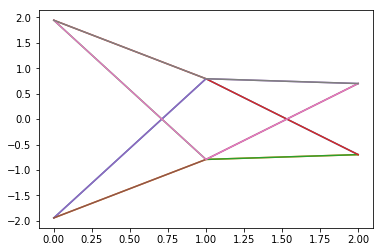

In [11]:
print(data.shape)
plt.plot(data)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


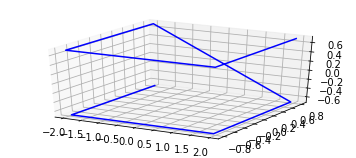

In [17]:
from mpl_toolkits.mplot3d import Axes3D
f2 = plt.figure()
# ax = Axes3D(f2)
ax = f2.gca(projection='3d')
ax.set_aspect("equal")
ax.plot3D(data[0], data[1],data[2], color="b")

# ax.scatter(data[0], data[1], data[2])
f2.show()

In [ ]:
def generate_boxes(tracklets):
    for tracklet_idx, tracklet in enumerate(tracklets):
        h, w, l = tracklet.size
        box_vol = h * w * l
        tracklet_box = lwh_to_box(l, w, h) # will create a 3D bounding box
        
        # print(tracklet_box)
        frame_idx = tracklet.first_frame
        for trans, rot in zip(tracklet.trans, tracklet.rots):
            # calc 3D bound box in capture vehicle oriented coordinates
            yaw = rot[2]  # rotations besides yaw should be 0
            rot_mat = np.array([
                [np.cos(yaw), -np.sin(yaw), 0.0],
                [np.sin(yaw), np.cos(yaw), 0.0],
                [0.0, 0.0, 1.0]])
            oriented_box = np.dot(rot_mat, tracklet_box) + np.tile(trans, (8, 1)).T
            yield frame_idx, tracklet_idx, tracklet.object_type, box_vol, oriented_box
            frame_idx += 1


In [11]:
n_values = 32
x = tf.linspace(-3.0, 3.0, n_values)

In [12]:
sess = tf.Session()
result = sess.run(x)
sess.close()
print(result)

[-3.         -2.80645156 -2.61290312 -2.41935492 -2.22580647 -2.03225803
 -1.83870971 -1.64516139 -1.45161295 -1.25806451 -1.06451619 -0.87096786
 -0.67741942 -0.48387098 -0.29032278 -0.09677434  0.0967741   0.29032254
  0.48387098  0.67741919  0.87096763  1.06451607  1.25806427  1.45161295
  1.64516115  1.83870935  2.03225803  2.22580624  2.41935444  2.61290312
  2.80645132  3.        ]


In [13]:
sess = tf.InteractiveSession()
sigma = 1.0
mean = 0.0
# Gaussian Distribution: e^( -(X - mean)^2 / (2 * sigma^2) ) * 1 / sigma * (2 * PI)^2
z = ( tf.exp( tf.negative( tf.pow(x - mean, 2.0) / (2.0 * tf.pow(sigma, 2.0)) ) ) * (1.0 / (sigma * tf.sqrt(2.0 * 3.1415))))

[ 0.00443191  0.0077737   0.01313394  0.02137437  0.03350599  0.05059209
  0.07358232  0.10308496  0.13910672  0.18081389  0.22638434  0.27301833
  0.31715256  0.35487509  0.38248441  0.39708439  0.39708439  0.38248444
  0.35487509  0.31715262  0.27301839  0.22638437  0.18081395  0.13910672
  0.103085    0.07358237  0.05059209  0.03350601  0.02137439  0.01313394
  0.0077737   0.00443191]


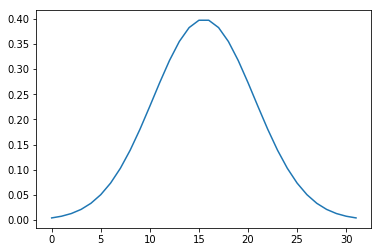

In [14]:
# %% Execute the graph and plot the result
plt.plot(z.eval())
print(z.eval())

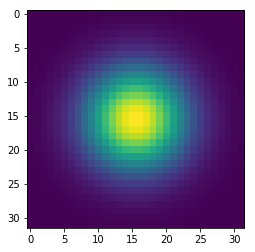

In [15]:
z_2d = tf.matmul(tf.reshape(z, [n_values, 1]), tf.reshape(z, [1, n_values]))
plt.imshow(z_2d.eval())

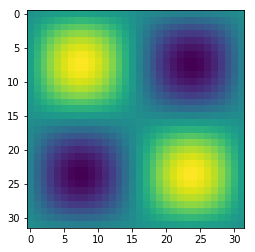

In [16]:
x = tf.sin(tf.linspace(-3.0, 3.0, n_values))
y = tf.matmul(tf.reshape(x, [n_values, 1]), tf.reshape(x, [1, n_values]))
plt.imshow(y.eval())

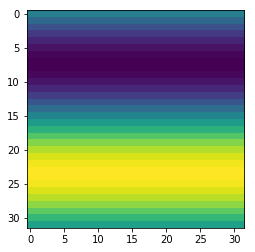

In [17]:
x = tf.reshape(tf.sin(tf.linspace(-3.0, 3.0, n_values)), [n_values, 1])
y = tf.reshape(tf.ones_like(x), [1, n_values])
z = tf.matmul(x, y)
plt.imshow(z.eval())

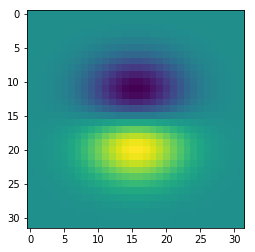

In [18]:
x = tf.reshape(tf.sin(tf.linspace(-3.0, 3.0, n_values)), [n_values, 1])
y = tf.reshape(tf.ones_like(x), [1, n_values])
z = tf.multiply(tf.matmul(x, y), z_2d)
plt.imshow(z.eval())

In [19]:
# %% We can also list all the operations of a graph:
ops = tf.get_default_graph().get_operations()
print([op.name for op in ops])

['LinSpace/start', 'LinSpace/stop', 'LinSpace/num', 'LinSpace', 'sub/y', 'sub', 'Pow/y', 'Pow', 'Pow_1/x', 'Pow_1/y', 'Pow_1', 'mul/x', 'mul', 'truediv', 'Neg', 'Exp', 'Sqrt/x', 'Sqrt', 'mul_1/x', 'mul_1', 'truediv_1/x', 'truediv_1', 'mul_2', 'Reshape/shape', 'Reshape', 'Reshape_1/shape', 'Reshape_1', 'MatMul', 'LinSpace_1/start', 'LinSpace_1/stop', 'LinSpace_1/num', 'LinSpace_1', 'Sin', 'Reshape_2/shape', 'Reshape_2', 'Reshape_3/shape', 'Reshape_3', 'MatMul_1', 'LinSpace_2/start', 'LinSpace_2/stop', 'LinSpace_2/num', 'LinSpace_2', 'Sin_1', 'Reshape_4/shape', 'Reshape_4', 'Reshape_5/shape', 'Reshape_5', 'MatMul_2', 'LinSpace_3/start', 'LinSpace_3/stop', 'LinSpace_3/num', 'LinSpace_3', 'Sin_2', 'Reshape_6/shape', 'Reshape_6', 'Reshape_7/shape', 'Reshape_7', 'MatMul_3', 'LinSpace_4/start', 'LinSpace_4/stop', 'LinSpace_4/num', 'LinSpace_4', 'sub_1/y', 'sub_1', 'Pow_2/y', 'Pow_2', 'Pow_3/x', 'Pow_3/y', 'Pow_3', 'mul_3/x', 'mul_3', 'truediv_2', 'Neg_1', 'Exp_1', 'Sqrt_1/x', 'Sqrt_1', 'mul_4

In [20]:

# %% Lets try creating a generic function for computing the same thing:
def gabor(n_values=32, sigma=1.0, mean=0.0):
    x = tf.linspace(-3.0, 3.0, n_values)
    z = (tf.exp(tf.negative(tf.pow(x - mean, 2.0) / (2.0 * tf.pow(sigma, 2.0)))) 
         * (1.0 / (sigma * tf.sqrt(2.0 * 3.1415))))
    gauss_kernel = tf.matmul(tf.reshape(z, [n_values, 1]), tf.reshape(z, [1, n_values]))
    
    x = tf.reshape(tf.sin(tf.linspace(-3.0, 3.0, n_values)), [n_values, 1])
    y = tf.reshape(tf.ones_like(x), [1, n_values])
    gabor_kernel = tf.multiply(tf.matmul(x, y), gauss_kernel)
    return gauss_kernel, gabor_kernel

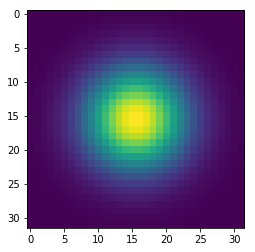

In [21]:
# %% Confirm this does something:
plt.imshow(gabor()[0].eval())

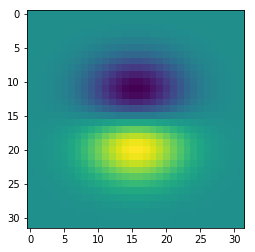

In [22]:
plt.imshow(gabor()[1].eval())

In [32]:

# %% And another function which can convolve
def convolve(img, W):
    # The W matrix is only 2D
    # But conv2d will need a tensor which is 4d:
    # height x width x n_input x n_output
    if len(W.get_shape()) == 2:
        dims = W.get_shape().as_list() + [1, 1]
        print('dims:', dims)
        W = tf.reshape(W, dims)

    if len(img.get_shape()) == 2:
        # num x height x width x channels
        dims = [1] + img.get_shape().as_list() + [1]
        img = tf.reshape(img, dims)
    elif len(img.get_shape()) == 3:
        dims = [1] + img.get_shape().as_list()
        img = tf.reshape(img, dims)
        # if the image is 3 channels, then our convolution
        # kernel needs to be repeated for each input channel
        print(img.shape)
        print('weight1: ', W.shape)
        W = tf.concat([W, W, W], 2)
        print('weight2: ', W.shape)

    # Stride is how many values to skip for the dimensions of
    # num, height, width, channels
    convolved = tf.nn.conv2d(img, W,
                             strides=[1, 1, 1, 1], padding='S')
    return convolved

(512, 512, 3)


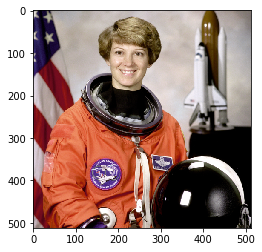

In [33]:
# %% Load up an image:
from skimage import data
img = data.astronaut()
plt.imshow(img)
print(img.shape)

In [34]:
# %% Now create a placeholder for our graph which can store any input:
x = tf.placeholder(tf.float32, shape=img.shape)
weight = gabor()[1]
print(weight.shape)

(32, 32)


In [35]:
# %% And a graph which can convolve our image with a gabor
out = convolve(x, weight)

dims: [32, 32, 1, 1]
(1, 512, 512, 3)
weight1:  (32, 32, 1, 1)
weight2:  (32, 32, 3, 1)


(481, 481)


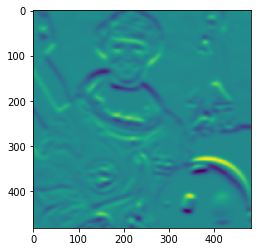

In [36]:
# %% Now send the image into the graph and compute the result
result = tf.squeeze(out).eval(feed_dict={x: img})
print(result.shape)
plt.imshow(result)

In [87]:

# %% And another function which can convolve
def convolve(img, W):
    # The W matrix is only 2D
    # But conv2d will need a tensor which is 4d:
    # height x width x n_input x n_output
    if len(W.get_shape()) == 2:
        dims = W.get_shape().as_list() + [1, 1]
        print(dims)
        W = tf.reshape(W, dims)

    if len(img.get_shape()) == 2:
        # num x height x width x channels
        dims = [1] + img.get_shape().as_list() + [1]
        img = tf.reshape(img, dims)
    elif len(img.get_shape()) == 3:
        dims = [1] + img.get_shape().as_list()
        img = tf.reshape(img, dims)
        # if the image is 3 channels, then our convolution
        # kernel needs to be repeated for each input channel
        print(img.shape)
        print('weight1: ', W.shape)
        W = tf.concat([W, W, W], 2)
        print('weight2: ', W.shape)
        W = tf.concat([W, W, W], 3)
        print('weight3: ', W.shape)

    # Stride is how many values to skip for the dimensions of
    # num, height, width, channels
    convolved = tf.nn.conv2d(img, W,
                             strides=[1, 1, 1, 1], padding='SAME')
    return convolved

(32, 32)
[32, 32, 1, 1]
(1, 512, 512, 3)
weight1:  (32, 32, 1, 1)
weight2:  (32, 32, 3, 1)
weight3:  (32, 32, 3, 3)


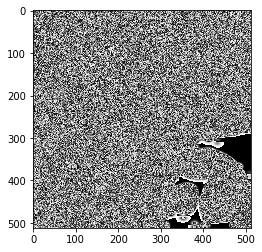

In [88]:
# %% Now create a placeholder for our graph which can store any input:
x = tf.placeholder(tf.float32, shape=img.shape)
weight = gabor()[1]
print(weight.shape)

# %% And a graph which can convolve our image with a gabor
out = convolve(x, weight)

# %% Now send the image into the graph and compute the result
result = tf.squeeze(out).eval(feed_dict={x: img})
plt.imshow(result)

In [15]:
sess = tf.Session()
a = tf.ones([6])
print(sess.run(a))
indices=[1,3,5]
print(sess.run(tf.scatter_nd([[1],[3],[5]], [1,2,1], [6])))

[ 1.  1.  1.  1.  1.  1.]
[0 1 0 2 0 1]
